In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Using TensorFlow backend.


Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


In [3]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, AveragePooling2D
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_dir = 'data/512/train/'
test_dir = "data/512/test"

extracted_features_dir = "extracted_features/"
model_name = "DenseNet121_512"

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))
print("***"*15)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/512/train/ 0
data/512/train/Invasive 1155
data/512/train/Benign 1155
data/512/train/InSitu 1155
data/512/train/Normal 1155
*********************************************
data/512/test 0
data/512/test/Invasive 25
data/512/test/Benign 25
data/512/test/InSitu 25
data/512/test/Normal 25


In [6]:
output_classes = 4
batch_size = 32
img_height, img_width = 512, 384
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152
nb_test_samples: 100

predict_size_train: 109
predict_size_validation: 36
predict_size_test: 4

 num_classes: 4


In [9]:
bottleneck_final_model = applications.DenseNet121(include_top=False, weights='imagenet', pooling='avg')

bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [10]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [11]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 2s - loss: 0.9996 - acc: 0.5750 - val_loss: 0.6740 - val_acc: 0.7613
Epoch 2/1000
 - 1s - loss: 0.6752 - acc: 0.7333 - val_loss: 0.5270 - val_acc: 0.8290
Epoch 3/1000
 - 1s - loss: 0.5308 - acc: 0.8005 - val_loss: 0.4315 - val_acc: 0.8646
Epoch 4/1000
 - 1s - loss: 0.4520 - acc: 0.8423 - val_loss: 0.3872 - val_acc: 0.8767
Epoch 5/1000
 - 1s - loss: 0.3864 - acc: 0.8691 - val_loss: 0.3181 - val_acc: 0.9080
Epoch 6/1000
 - 1s - loss: 0.3245 - acc: 0.8919 - val_loss: 0.2754 - val_acc: 0.9201
Epoch 7/1000
 - 1s - loss: 0.2976 - acc: 0.9034 - val_loss: 0.2265 - val_acc: 0.9470
Epoch 8/1000
 - 1s - loss: 0.2560 - acc: 0.9259 - val_loss: 0.2324 - val_acc: 0.9297
Epoch 9/1000
 - 1s - loss: 0.2299 - acc: 0.9311 - val_loss: 0.1801 - val_acc: 0.9601
Epoch 10/1000
 - 1s - loss: 0.2103 - acc: 0.9403 - val_loss: 0.1656 - val_acc: 0.9627
Epoch 11/1000
 - 1s - loss: 0.1934 - acc: 0.9446 - val_loss: 0.1636 - val_acc: 0.9583
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9948
Epoch 97/1000
 - 1s - loss: 0.0143 - acc: 0.9980 - val_loss: 0.0254 - val_acc: 0.9957
Epoch 98/1000
 - 1s - loss: 0.0128 - acc: 0.9988 - val_loss: 0.0266 - val_acc: 0.9939
Epoch 99/1000
 - 1s - loss: 0.0110 - acc: 0.9997 - val_loss: 0.0263 - val_acc: 0.9931
Epoch 100/1000
 - 1s - loss: 0.0115 - acc: 0.9994 - val_loss: 0.0257 - val_acc: 0.9948
Epoch 101/1000
 - 1s - loss: 0.0127 - acc: 0.9988 - val_loss: 0.0284 - val_acc: 0.9939
Epoch 102/1000
 - 1s - loss: 0.0115 - acc: 0.9994 - val_loss: 0.0267 - val_acc: 0.9939
Epoch 103/1000
 - 1s - loss: 0.0109 - acc: 0.9997 - val_loss: 0.0243 - val_acc: 0.9948
Epoch 104/1000
 - 1s - loss: 0.0103 - acc: 0.9991 - val_loss: 0.0268 - val_acc: 0.9948
Epoch 105/1000
 - 1s - loss: 0.0102 - acc: 0.9997 - val_loss: 0.0246 - val_acc: 0.9948
Epoch 106/1000
 - 1s - loss: 0.0109 - acc: 0.9986 - val_loss: 0.0264 - val_acc: 0.9939
Epoch 107/1000
 - 1s - loss: 0.0116 - acc: 0.99

Epoch 191/1000
 - 1s - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 0.9939
Epoch 192/1000
 - 1s - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0217 - val_acc: 0.9939
Epoch 193/1000
 - 1s - loss: 0.0052 - acc: 0.9997 - val_loss: 0.0228 - val_acc: 0.9948
Epoch 194/1000
 - 1s - loss: 0.0053 - acc: 0.9997 - val_loss: 0.0220 - val_acc: 0.9939
Epoch 195/1000
 - 1s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 0.9939
Epoch 196/1000
 - 1s - loss: 0.0060 - acc: 0.9994 - val_loss: 0.0236 - val_acc: 0.9948
Epoch 197/1000
 - 1s - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0229 - val_acc: 0.9939
Epoch 198/1000
 - 1s - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0214 - val_acc: 0.9939
Epoch 199/1000
 - 1s - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0217 - val_acc: 0.9939
Epoch 200/1000
 - 1s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9948
Epoch 201/1000
 - 1s - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9939
Epoch 202/1000
 - 1s - loss: 0.0047 - acc: 

 - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9939
Epoch 286/1000
 - 1s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 287/1000
 - 1s - loss: 0.0033 - acc: 0.9997 - val_loss: 0.0214 - val_acc: 0.9939
Epoch 288/1000
 - 1s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0205 - val_acc: 0.9939
Epoch 289/1000
 - 1s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9939
Epoch 290/1000
 - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0193 - val_acc: 0.9948
Epoch 291/1000
 - 1s - loss: 0.0035 - acc: 0.9997 - val_loss: 0.0209 - val_acc: 0.9939
Epoch 292/1000
 - 1s - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0201 - val_acc: 0.9939
Epoch 293/1000
 - 1s - loss: 0.0037 - acc: 0.9997 - val_loss: 0.0186 - val_acc: 0.9939
Epoch 294/1000
 - 1s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9939
Epoch 295/1000
 - 1s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9939
Epoch 296/1000
 - 1s - loss: 0.0034 - acc: 1.0000 - val_lo

Epoch 380/1000
 - 1s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9939
Epoch 381/1000
 - 1s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 382/1000
 - 1s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9939
Epoch 383/1000
 - 1s - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0210 - val_acc: 0.9939
Epoch 384/1000
 - 1s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 0.9939
Epoch 385/1000
 - 1s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9948
Epoch 386/1000
 - 1s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 0.9939
Epoch 387/1000
 - 1s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0193 - val_acc: 0.9939
Epoch 388/1000
 - 1s - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0199 - val_acc: 0.9939
Epoch 389/1000
 - 1s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 0.9939
Epoch 390/1000
 - 1s - loss: 0.0029 - acc: 0.9997 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 391/1000
 - 1s - loss: 0.0024 - acc: 

 - 1s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 0.9939
Epoch 475/1000
 - 1s - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0187 - val_acc: 0.9939
Epoch 476/1000
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9939
Epoch 477/1000
 - 1s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 478/1000
 - 1s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9939
Epoch 479/1000
 - 1s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9939
Epoch 480/1000
 - 1s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9948
Epoch 481/1000
 - 1s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9948
Epoch 482/1000
 - 1s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9948
Epoch 483/1000
 - 1s - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0184 - val_acc: 0.9939
Epoch 484/1000
 - 1s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 0.9948
Epoch 485/1000
 - 1s - loss: 0.0019 - acc: 1.0000 - val_lo

Epoch 569/1000
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9939
Epoch 570/1000
 - 1s - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0199 - val_acc: 0.9939
Epoch 571/1000
 - 1s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9948
Epoch 572/1000
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9939
Epoch 573/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9939
Epoch 574/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9939
Epoch 575/1000
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 0.9939
Epoch 576/1000
 - 1s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9939
Epoch 577/1000
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9939
Epoch 578/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9939
Epoch 579/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 0.9939
Epoch 580/1000
 - 1s - loss: 0.0013 - acc: 

 - 1s - loss: 8.7066e-04 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9939
Epoch 664/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 0.9939
Epoch 665/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9939
Epoch 666/1000
 - 1s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9939
Epoch 667/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0188 - val_acc: 0.9948
Epoch 668/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 0.9939
Epoch 669/1000
 - 1s - loss: 9.8865e-04 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 670/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 0.9939
Epoch 671/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 672/1000
 - 1s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 0.9939
Epoch 673/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9939
Epoch 674/1000
 - 1s - loss: 0.0011 - acc: 0.9997 

Epoch 756/1000
 - 1s - loss: 7.9675e-04 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9939
Epoch 757/1000
 - 1s - loss: 7.8233e-04 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 758/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9939
Epoch 759/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9939
Epoch 760/1000
 - 1s - loss: 9.6421e-04 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9939
Epoch 761/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 0.9939
Epoch 762/1000
 - 1s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9939
Epoch 763/1000
 - 1s - loss: 9.6815e-04 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 764/1000
 - 1s - loss: 7.6203e-04 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 0.9939
Epoch 765/1000
 - 1s - loss: 9.2593e-04 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 0.9939
Epoch 766/1000
 - 1s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0205 - val_acc: 0.9939
Epoch 767/1000
 - 1

Epoch 848/1000
 - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.9939
Epoch 849/1000
 - 1s - loss: 9.7585e-04 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.9939
Epoch 850/1000
 - 1s - loss: 8.1569e-04 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9939
Epoch 851/1000
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9939
Epoch 852/1000
 - 1s - loss: 9.2036e-04 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 0.9948
Epoch 853/1000
 - 1s - loss: 8.7379e-04 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9939
Epoch 854/1000
 - 1s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9939
Epoch 855/1000
 - 1s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0202 - val_acc: 0.9948
Epoch 856/1000
 - 1s - loss: 8.2283e-04 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9939
Epoch 857/1000
 - 1s - loss: 9.5709e-04 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9948
Epoch 858/1000
 - 1s - loss: 8.3284e-04 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 0.9939
Epoch 859/1000


 - 1s - loss: 8.0808e-04 - acc: 1.0000 - val_loss: 0.0221 - val_acc: 0.9939
Epoch 940/1000
 - 1s - loss: 7.0643e-04 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9948
Epoch 941/1000
 - 1s - loss: 8.4178e-04 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 0.9939
Epoch 942/1000
 - 1s - loss: 8.9913e-04 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.9948
Epoch 943/1000
 - 1s - loss: 7.8732e-04 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9948
Epoch 944/1000
 - 1s - loss: 6.3566e-04 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 0.9948
Epoch 945/1000
 - 1s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0210 - val_acc: 0.9948
Epoch 946/1000
 - 1s - loss: 8.1753e-04 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9948
Epoch 947/1000
 - 1s - loss: 9.0949e-04 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 0.9948
Epoch 948/1000
 - 1s - loss: 7.3578e-04 - acc: 1.0000 - val_loss: 0.0221 - val_acc: 0.9948
Epoch 949/1000
 - 1s - loss: 7.6704e-04 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9939
Epoch 950/1000
 - 

In [12]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.87


Confusion Matrix
[[21  1  0  3]
 [ 1 22  1  1]
 [ 1  2 22  0]
 [ 3  0  0 22]]


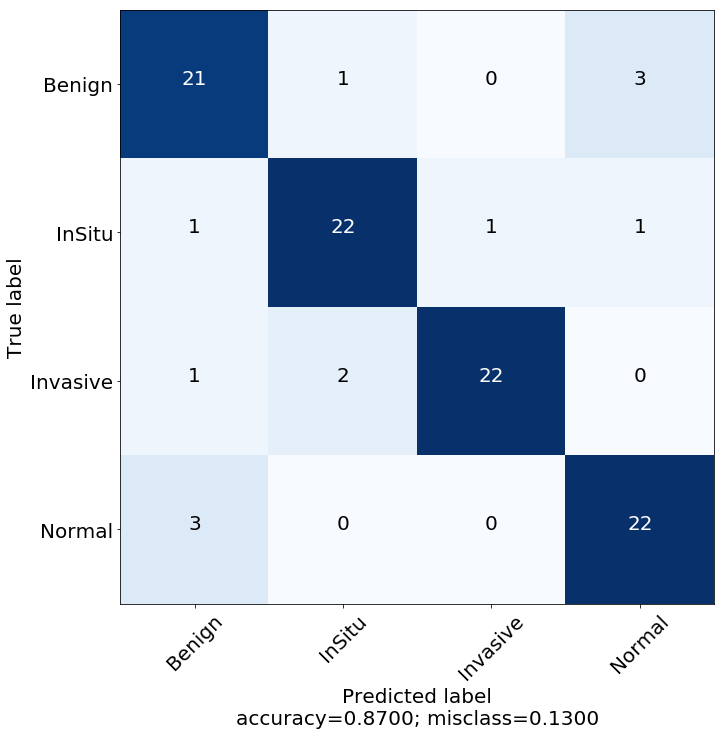

In [13]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  1  0  3]
 [ 1 22  1  1]
 [ 1  2 22  0]
 [ 3  0  0 22]]
              precision    recall  f1-score   support

      Benign       0.81      0.84      0.82        25
      InSitu       0.88      0.88      0.88        25
    Invasive       0.96      0.88      0.92        25
      Normal       0.85      0.88      0.86        25

   micro avg       0.87      0.87      0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [15]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.45454545454545
Specificity :  95.65217391304348


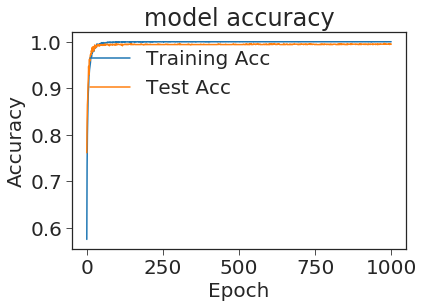

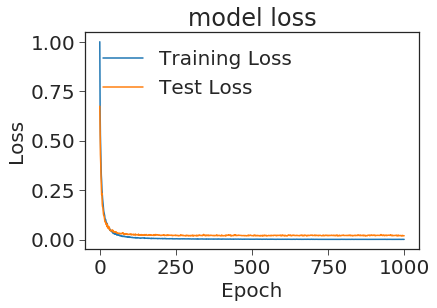

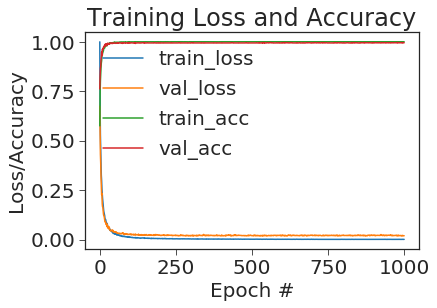

In [16]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

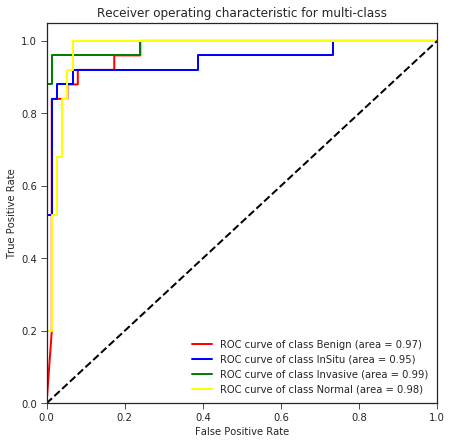

In [17]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3])
y_pred_binary = y_pred_probabilities
n_classes=4
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

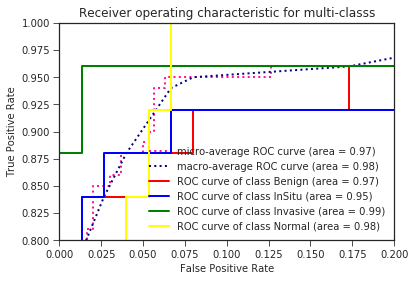

In [18]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
# plt.savefig('') 
plt.show()

In [19]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]

100/100 [==============================] - 0s 208us/step


In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

Precision =  0.8725919732441472
Recall =  0.87
f1_score =  0.8707352941176469


In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9133333333333331
